In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
seed = 42
rng = np.random.RandomState(seed)

In [3]:
data = pd.read_csv('../datasets/facial_keypoint_identification/facial_keypoint_identification.csv')

In [4]:
data.head()

,image_name,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y
0,0.jpg,66,39,30,36
1,1.jpg,64,34,29,33
2,2.jpg,65,34,30,34
3,3.jpg,65,37,32,37
4,4.jpg,66,39,32,38


Shape of original image is (96, 96, 3)


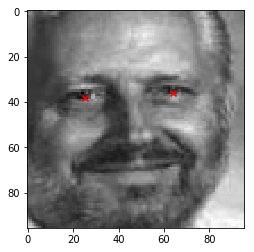

In [11]:
# get random index of data
idx = rng.choice(data.index)

# read image
img = plt.imread('../datasets/facial_keypoint_identification/images/' + data.image_name.iloc[idx])

# create an empty figure
fig = plt.figure()

# plot image
plt.imshow(img)

# plot target
plt.scatter(data.left_eye_center_x.iloc[idx], data.left_eye_center_y.iloc[idx], marker='x', c='r')
plt.scatter(data.right_eye_center_x.iloc[idx], data.right_eye_center_y.iloc[idx], marker='x', c='r')

# print image shape
print('Shape of original image is', img.shape)

# show figure
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

In [15]:
error_left_x = mean_squared_error(data.left_eye_center_x.values, np.full(data.left_eye_center_x.values.shape, data.left_eye_center_x.mean()))
error_left_y = mean_squared_error(data.left_eye_center_y.values, np.full(data.left_eye_center_y.values.shape, data.left_eye_center_y.mean()))
error_right_x = mean_squared_error(data.right_eye_center_x.values, np.full(data.right_eye_center_x.values.shape, data.right_eye_center_x.mean()))
error_right_y = mean_squared_error(data.right_eye_center_y.values, np.full(data.right_eye_center_y.values.shape, data.right_eye_center_y.mean()))

error = (error_left_x*error_left_x + error_left_y*error_left_y + error_right_x*error_right_x + error_right_y*error_right_y) / 4
error

104.5789947402131

In [16]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

In [17]:
images = []
for img in data.image_name:
    img = image.load_img('../datasets/facial_keypoint_identification/images/' + img, target_size=(224, 224, 3))
    img = image.img_to_array(img)
    images.append(img)
    
images = np.array(images)

In [18]:
images.shape

(7033, 224, 224, 3)

In [19]:
X = preprocess_input(images, mode='tf')
y = data.iloc[:, 1:].values

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, InputLayer
from keras.callbacks import EarlyStopping

In [22]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [23]:
features_train = base_model.predict(X_train)
features_valid = base_model.predict(X_valid)

In [24]:
features_train.max()

10.810992

In [25]:
max_val = features_train.max()

features_train /= max_val
features_valid /= max_val

In [26]:
features_train = features_train.reshape(features_train.shape[0], 7*7*512)
features_valid = features_valid.reshape(features_valid.shape[0], 7*7*512)

In [27]:
model = Sequential()

model.add(InputLayer((7*7*512, )))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=4, activation='linear'))

adam = Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=adam)

In [28]:
estop = EarlyStopping(patience=10, mode='min', min_delta=0.001, monitor='val_loss')

In [29]:
model.fit(features_train, y_train, epochs=200, batch_size=512, validation_data=(features_valid, y_valid), callbacks=[estop])

Train on 4923 samples, validate on 2110 samples
Epoch 1/200
4923/4923 [==============================] - 1s 220us/step - loss: 1174.9048 - val_loss: 163.5989
Epoch 2/200
4923/4923 [==============================] - 1s 105us/step - loss: 150.7307 - val_loss: 188.2971
Epoch 3/200
4923/4923 [==============================] - 1s 104us/step - loss: 93.1750 - val_loss: 56.6709
Epoch 4/200
4923/4923 [==============================] - 1s 104us/step - loss: 60.0093 - val_loss: 34.1627
Epoch 5/200
4923/4923 [==============================] - 1s 105us/step - loss: 34.6466 - val_loss: 25.7038
Epoch 6/200
4923/4923 [==============================] - 1s 105us/step - loss: 28.2784 - val_loss: 19.2272
Epoch 7/200
4923/4923 [==============================] - 1s 104us/step - loss: 23.8032 - val_loss: 16.5836
Epoch 8/200
4923/4923 [==============================] - 1s 102us/step - loss: 21.1161 - val_loss: 14.9985
Epoch 9/200
4923/4923 [==============================] - 1s 104us/step - loss: 19.9412 - va

4923/4923 [==============================] - 1s 105us/step - loss: 6.1586 - val_loss: 5.3247
Epoch 78/200
4923/4923 [==============================] - 1s 104us/step - loss: 6.1735 - val_loss: 5.2831
Epoch 79/200
4923/4923 [==============================] - 1s 104us/step - loss: 6.0867 - val_loss: 5.2402
Epoch 80/200
4923/4923 [==============================] - 1s 104us/step - loss: 6.0248 - val_loss: 5.2214
Epoch 81/200
4923/4923 [==============================] - 1s 103us/step - loss: 6.0318 - val_loss: 5.2379
Epoch 82/200
4923/4923 [==============================] - 0s 101us/step - loss: 6.0431 - val_loss: 5.1970
Epoch 83/200
4923/4923 [==============================] - 1s 103us/step - loss: 5.8859 - val_loss: 5.1793
Epoch 84/200
4923/4923 [==============================] - 0s 101us/step - loss: 5.7955 - val_loss: 5.1691
Epoch 85/200
4923/4923 [==============================] - 1s 102us/step - loss: 5.9031 - val_loss: 5.1961
Epoch 86/200
4923/4923 [==============================] - 1

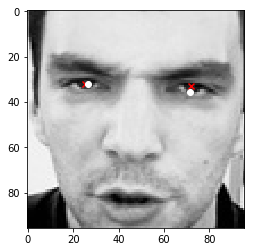

In [42]:
# get predictions
predictions = model.predict(features_valid)

# extract validation images
_, valid_images, _, _ = train_test_split(data.image_name.values, y, test_size=0.3, random_state=42)

# get random validation image index
idx = rng.choice(range(len(valid_images)))

# get corresponding image name
image_name = valid_images[idx]

# get actual targets
left_x = data.loc[data.image_name == image_name, 'left_eye_center_x']
left_y = data.loc[data.image_name == image_name, 'left_eye_center_y']
right_x = data.loc[data.image_name == image_name, 'right_eye_center_x']
right_y = data.loc[data.image_name == image_name, 'right_eye_center_y']

# get corresponding predictions
pred_left_x, pred_left_y, pred_right_x, pred_right_y = predictions[idx]

# read image
img = plt.imread('../datasets/facial_keypoint_identification/images/' + image_name)

# plot empty figure
fig = plt.figure()

# plot image
plt.imshow(img, cmap='gray')

# plot actual targets
plt.scatter(left_x, left_y, marker='x', c='r')
plt.scatter(right_x, right_y, marker='x', c='r')

# plot predictions
plt.scatter(pred_left_x, pred_left_y, marker='o', c='w')
plt.scatter(pred_right_x, pred_right_y, marker='o', c='w')

# show figure
plt.show()